In [137]:
%matplotlib inline

In [138]:
import pandas as pds
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pathlib import Path
import geopandas as gpd
import pickle
import datetime as dt
import geopandas as gpds
import geopandas as gpd
import pickle
import xarray as xr
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from shapely.geometry import MultiPolygon
from fiona.crs import from_epsg
pds.set_option('display.max_rows', 500)

# Define paths

In [139]:
# Define paths to files
gauges_path = Path(r'C:\Users\hordurbhe\Dropbox\UW\lamah_ice\GIS\watersheds\final_watersheds\gauges_with_splitted_included.shp') 
wsheds_path = Path(r'C:\Users\hordurbhe\Dropbox\UW\lamah_ice\GIS\watersheds\final_watersheds\final_watersheds\Basins_A.shp')
valid_years_path = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\1_attributes\final_attributes\valid_years_10_perc_tol_1981_2021.csv")
valid_years_unfiltered_path = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\1_attributes\final_attributes\valid_years_10_perc_tol_1981_2021_unfiltered_including_unchecked.csv")

streamflow_ind_path = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\1_attributes\final_attributes\hydro_sign_10_perc_tol_only_more_than_2_years_1981_2021.csv")
streamflow_ind_path_unfilt = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\1_attributes\final_attributes\hydro_sign_10_perc_tol_only_more_than_2_years_1981_2021_unfiltered_including_unchecked.csv")
soil_path = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\1_attributes\final_attributes\soil_attrs_basins_A.csv")
human_infl_path = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\1_attributes\final_attributes\human_influence_cleaned_reordered.csv")
NI_geo_attrs_path = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\1_attributes\final_attributes\NI_geo_attrs_basins_A.csv")
topo_attrs_path = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\1_attributes\final_attributes\topo_attrs_Basins_A.csv")
clim_ind_path = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\1_attributes\final_attributes\Clim_ind_1989_2009.csv")
water_balance_path = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\1_attributes\final_attributes\water_balance.csv")
# water_balance_path_unfiltered_obs = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\1_attributes\water_balance_unfiltered.csv")
water_balance_path_including_unchecked = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\1_attributes\final_attributes\water_balance_unfiltered_including_unchecked.csv")

# Read files

In [140]:
# Read gauges shapefile
gauges = gpds.read_file(gauges_path)
gauges = gauges.set_index('id')
cols = ['st_numer', 'st_nafn', 'vhm_numer', 'vatnsfall', 'gagnaeigan', 'stada', 'upphaf_rek','dags_aflag', 'elevation']
gauges_reduced = gauges[cols]
gauges_reduced.columns = ['V_no','name','VHM_no','river','data_owner','status','upphaf_rek','dags_aflag', 'elevation']

# Read watershed attributes (calculated in QGIS)
wsheds_attrs = gpds.read_file(wsheds_path)
wsheds_attrs.index = wsheds_attrs['id']
wsheds_attrs = wsheds_attrs.drop(columns=['id'])
wsheds_attrs['lat'] = gauges.geometry.y
wsheds_attrs['lon'] = gauges.geometry.x
# Drop columns from wsheds_attrs that have no values
wsheds_attrs.dropna(axis=1, how='all', inplace=True)
# Extract only the relevant columns from wsheds_attrs
wsheds_attrs = wsheds_attrs[['forest_fra', 'gc_dom', 'strm_dens', 'mvert_dist', 'gc_ss_fra', 'area_calc', 'gc_wb_fra', 'litho_vapy', 'agr_fra', 'gc_py_fra', 'litho_dom', 'gc_ig_fra', 'elon_ratio', 'bare_fra', 'lon', 'litho_pb', 'glac_fra', 'gc_sm_fra', 'lc_dom', 'mvert_ang', 'gc_vb_fra', 'gc_mt_fra', 'litho_vbsr', 'gc_pi_fra', 'lake_fra', 'urban_fra', 'gc_va_fra', 'gc_su_fra', 'litho_pavr', 'litho_vbpy', 'gc_pb_fra', 'litho_vb', 'lat', 'gc_sc_fra', 'gc_pa_fra','lai_max', 'lai_diff', 'ndvi_max', 'ndvi_min','gvf_max', 'gvf_diff','geometry']]

# # Read streamflow indices
valid_years_df = pds.read_csv(valid_years_path)
valid_years_df = valid_years_df.set_index('Unnamed: 0')
valid_years_df.index = valid_years_df.index.rename('id')

valid_years_df_unfiltered = pds.read_csv(valid_years_unfiltered_path)
valid_years_df_unfiltered = valid_years_df_unfiltered.set_index('Unnamed: 0')
valid_years_df_unfiltered.index = valid_years_df_unfiltered.index.rename('id')
valid_years_df_unfiltered.columns=['year_count_unfilt']

# Read streamflow indices
streamflow_indices = pds.read_csv(streamflow_ind_path)
streamflow_indices = streamflow_indices.set_index('Unnamed: 0')
streamflow_indices.index = streamflow_indices.index.rename('id')

streamflow_indices_unfilt = pds.read_csv(streamflow_ind_path_unfilt)
streamflow_indices_unfilt = streamflow_indices_unfilt.set_index('Unnamed: 0')
streamflow_indices_unfilt.index = streamflow_indices_unfilt.index.rename('id')
newcols = [x+'_unfilt' for x in streamflow_indices_unfilt.columns]
streamflow_indices_unfilt.columns = newcols

# Read the soil attributes where depth to bedrock is calculated by excluding the glaciated regions
soil_indices = pds.read_csv(soil_path)
soil_indices = soil_indices.set_index('Unnamed: 0')
soil_indices.index = soil_indices.index.rename('id')

NI_geo_attrs = pds.read_csv(NI_geo_attrs_path)
NI_geo_attrs = NI_geo_attrs.set_index('ID')
NI_geo_attrs.index = NI_geo_attrs.index.rename('id')

# Read the (human) influence attributes
influence = pds.read_csv(human_infl_path,sep='\t',encoding='UTF-16')
influence = influence.set_index('id')

# Read csv with water balance stats (created here: http://localhost:8888/notebooks/Dropbox/UW/lamah_ice/Notebooks/streamflow_indices_in_python_and_water_balance_stats_valid_years_only.ipynb)
water_balance_df = pds.read_csv(water_balance_path)
water_balance_df = water_balance_df.set_index('Unnamed: 0')

water_balance_df_including_unchecked = pds.read_csv(water_balance_path_including_unchecked)
water_balance_df_including_unchecked = water_balance_df_including_unchecked.set_index('Unnamed: 0')
newcols = [x+'_unfilt' for x in water_balance_df_including_unchecked.columns]
water_balance_df_including_unchecked.columns = newcols

# Topographical attributes
topo_attrs = pds.read_csv(topo_attrs_path,sep=';')
topo_attrs = topo_attrs.set_index('id')

# Read ERA-Land data
era5_data = pds.read_csv(clim_ind_path,sep=';') 
era5_data.index=era5_data['ID']
era5_data.index = era5_data.index.rename('id')

In [26]:
# Final (using july20th streamflow export)
# Print some stats on the water balance using different versions of the streamflow observations
QP_era = water_balance_df['Value mm'].mean() - water_balance_df['P'].mean()
QP_rav = water_balance_df['Value mm'].mean() - water_balance_df['P_rav'].mean()
# QP_era_QQ100_included = water_balance_df_unfiltered['Value mm'].mean() - water_balance_df_unfiltered['P'].mean()
# QP_rav_QQ100_included = water_balance_df_unfiltered['Value mm'].mean() - water_balance_df_unfiltered['P_rav'].mean()
QP_era_all_obs = water_balance_df_including_unchecked['Value mm_unfilt'].mean()-water_balance_df_including_unchecked['P_unfilt'].mean()
QP_rav_all_obs = water_balance_df_including_unchecked['Value mm_unfilt'].mean()-water_balance_df_including_unchecked['P_rav_unfilt'].mean()

print('Using filtered obs and ERA5-Land, the average Q-P is %.2f mm' %(QP_era))
print('Using filtered obs and RAV-II, the average Q-P is %.2f mm' %(QP_rav))
print(' ')
# print('Using all QQ100 obs and ERA5-Land, the average Q-P is %.2f mm' %(QP_era_QQ100_included))
# print('Using all QQ100 obs and RAV-II, the average Q-P is %.2f mm' %(QP_rav_QQ100_included))
print(' ')
print('Using all obs and ERA5-Land, the average Q-P is %.2f mm' %(QP_era_all_obs))
print('Using all obs and RAV-II, the average Q-P is %.2f mm' %(QP_rav_all_obs))

Using filtered obs and ERA5-Land, the average Q-P is 1.43 mm
Using filtered obs and RAV-II, the average Q-P is 0.71 mm
 
 
Using all obs and ERA5-Land, the average Q-P is 1.20 mm
Using all obs and RAV-II, the average Q-P is 0.55 mm


# Merge all dataframes

In [149]:
# merge all the DataFrames based on their index
merged_df = wsheds_attrs.sort_index().merge(soil_indices.sort_index(),left_index=True, right_index=True).merge(NI_geo_attrs.sort_index(), left_index=True, right_index=True).merge(influence.sort_index(), left_index=True, right_index=True).merge(era5_data.sort_index(), left_index=True, right_index=True).merge(topo_attrs.sort_index(), left_index=True, right_index=True)
# Streamflow indices have missing data, so we do how='left' in this case
merged_dff = merged_df.merge(streamflow_indices.sort_index(), left_index=True, right_index=True, how='left').merge(streamflow_indices_unfilt.sort_index(), left_index=True, right_index=True, how='left')
merged_dff = merged_dff.merge(valid_years_df_unfiltered.sort_index(), left_index=True, right_index=True,how='left').merge(valid_years_df.sort_index(), left_index=True, right_index=True,how='left').merge(water_balance_df_including_unchecked.sort_index(), left_index=True, right_index=True,how='left').merge(water_balance_df.sort_index(), left_index=True, right_index=True,how='left').merge(gauges_reduced.sort_index(), left_index=True, right_index=True,how='left')

merged_dff.geometry = gauges.geometry
type(merged_dff)

geopandas.geodataframe.GeoDataFrame

In [9]:
# Check correlations between catchment characteristics:
corr = merged_dff.corr()
corr

,lai_max,lai_diff,ndvi_max,ndvi_min,gvf_max,gvf_diff,bedrk_dep_x,oc_fra_x,clay_fra,grav_fra,...,ET_unfilt,water_year_unfilt,P_rav_unfilt,Value mm,Quality,P,PET,ET,water_year,P_rav
lai_max,1.000000,0.999762,0.962958,0.799725,0.963621,0.963688,0.013021,-0.334195,-0.166157,-0.308885,...,0.677193,0.035275,-0.154940,-0.059763,-0.127950,-0.008278,0.654761,0.684218,0.118542,-0.156391
lai_diff,0.999762,1.000000,0.962201,0.797617,0.963230,0.963293,0.001704,-0.330306,-0.167239,-0.308198,...,0.671212,0.037030,-0.156538,-0.064429,-0.125913,-0.014235,0.647118,0.676648,0.119161,-0.157872
ndvi_max,0.962958,0.962201,1.000000,0.787661,0.996767,0.996811,0.032017,-0.344689,-0.191332,-0.337831,...,0.683318,-0.008528,-0.096784,-0.001124,-0.124434,0.078721,0.675786,0.716795,0.140273,-0.072588
ndvi_min,0.799725,0.797617,0.787661,1.000000,0.765703,0.765128,0.181114,-0.293741,-0.157427,-0.306327,...,0.881762,0.061298,-0.134602,0.035156,-0.219528,0.143372,0.822391,0.880206,0.123995,-0.158810
gvf_max,0.963621,0.963230,0.996767,0.765703,1.000000,0.999993,0.011982,-0.325071,-0.191164,-0.329301,...,0.647393,-0.007885,-0.107556,-0.015168,-0.113243,0.057196,0.634259,0.680593,0.130158,-0.081927
gvf_diff,0.963688,0.963293,0.996811,0.765128,0.999993,1.000000,0.012061,-0.325279,-0.191774,-0.329974,...,0.647288,-0.007628,-0.107875,-0.015322,-0.112236,0.056280,0.634323,0.680578,0.130541,-0.082249
bedrk_dep_x,0.013021,0.001704,0.032017,0.181114,0.011982,0.012061,1.000000,-0.118774,-0.219995,-0.264195,...,0.372929,-0.040579,-0.179711,0.070931,-0.186363,0.081288,0.399411,0.416325,-0.062424,-0.184044
oc_fra_x,-0.334195,-0.330306,-0.344689,-0.293741,-0.325071,-0.325279,-0.118774,1.000000,0.166623,0.318212,...,-0.290950,0.161771,0.041758,0.046997,0.134395,-0.054896,-0.372699,-0.297667,0.030939,0.038717
clay_fra,-0.166157,-0.167239,-0.191332,-0.157427,-0.191164,-0.191774,-0.219995,0.166623,1.000000,0.965003,...,-0.064243,-0.116018,0.279958,0.131984,0.259472,0.281369,-0.008961,-0.030365,0.034565,0.300506
grav_fra,-0.308885,-0.308198,-0.337831,-0.306327,-0.329301,-0.329974,-0.264195,0.318212,0.965003,1.000000,...,-0.244049,-0.077489,0.277030,0.143667,0.286436,0.251946,-0.246065,-0.251696,0.027917,0.300660


# Prepare water balance plots

In [31]:
# We read glacier weather:
# Read RAV-II data
start='1990-10-01'
rav_end = '2019-08-31'
rav_dict = dict()
for wshed in [20000,20001,20002]:
    path = Path(r'C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\rav2\ID_%s.csv' % wshed)
    df = pds.read_csv(path)
    df = df.set_index('Time')
    df.index = pds.to_datetime(df.index)
    df = df[start:rav_end]
    rav_dict[wshed] = df

# Read CARRA data    
carra_start='1991-10-01'
carra_end = '2022-08-31'
carra_dict = dict()
for wshed in [20000,20001,20002]:
    path = Path(r'C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\carra\precip_daily\ID_%s.csv' % wshed)
    df = pds.read_csv(path)
    df = df.set_index('time')
    df.index = pds.to_datetime(df.index)
    df = df[carra_start:carra_end]
    carra_dict[wshed] = df

# Read ERA5-land precip
era_path=Path(r"C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\era5_land\ts_glaciers\daily\ERA5L_total_precipitation.csv")
era = pds.read_csv(era_path)
era5=era.set_index('YYYY MM DD')
era5.index = pds.to_datetime(era5.index)

# Create lists containing annual winter accumulation from era5land
vatna_list = []
lang_list = []
hofs_list = []
for year in range(1992,2022):
    start = '%s-10-15' % int(year-1)
    end = '%s-05-01' % year
    winter_precip = era5[start:end].sum()
    vatna_list.append(winter_precip['1'])
    lang_list.append(winter_precip['2'])
    hofs_list.append(winter_precip['3'])

# Create lists containing annual winter accumulation from rav-ii
vatna_list_rav = []
lang_list_rav = []
hofs_list_rav = []
for year in range(1992,2020):
    start = '%s-10-15' % int(year-1)
    end = '%s-05-01' % year
    vatna_list_rav.append(rav_dict[20000][start:end].sum())
    lang_list_rav.append(rav_dict[20001][start:end].sum())
    hofs_list_rav.append(rav_dict[20002][start:end].sum())
    
# Create lists containing annual winter accumulation from CARRA
vatna_list_carra = []
lang_list_carra = []
hofs_list_carra = []
for year in range(1992,2023):
    start = '%s-10-15' % int(year-1)
    end = '%s-05-01' % year
    vatna_list_carra.append(carra_dict[20000][start:end].sum())
    lang_list_carra.append(carra_dict[20001][start:end].sum())
    hofs_list_carra.append(carra_dict[20002][start:end].sum())
    
lang_slod = Path(r"C:\Users\hordurbhe\OneDrive - Landsvirkjun\afkomukort\Langjokull_SMB_maps_2022_11_16.nc")
vatna_slod = Path(r"C:\Users\hordurbhe\OneDrive - Landsvirkjun\afkomukort\Vatnajokull_SMB_maps_2022_11_16.nc")
ds_lang = xr.open_dataset(lang_slod)
ds_vatna = xr.open_dataset(vatna_slod)

# Prepare figure plotting

In [32]:
# Specify some plot attributes
iceland_shapefile_color = 'gray'
glaciers_color = 'white'

# Specify where to save the figures
savepath = Path(r'C:\Users\hordurbhe\Dropbox\UW\lamah_ice\paper\figures\final')

# Define the date string for plot savenames
today = dt.date.today()
today_str = '%s-%s-%s' % (today.year,today.month,today.day)

# Set figure limits
minx, miny = 222375, 307671
maxx, maxy = 765246, 697520

# Define the plot helper function
def plot_figs(basemap,glaciers,ax,iceland_shapefile_color,glaciers_color):
    # This function plots the basemap, the glaciers and sets x,ylimits and x,yticks
    bmap.plot(ax=ax, color=iceland_shapefile_color)
    glaciers.plot(ax=ax,facecolor=glaciers_color,edgecolor='none')
    ax.set_xlim(minx,maxx)
    ax.set_ylim(miny,maxy)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    
# Read basemap for Iceland
bmap = gpds.read_file(r'C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\stanford-xz811fy7881-shapefile\island_isn93.shp')

# Read glacier outlines
gpath = Path(r'C:\Users\hordurbhe\Dropbox\UW\lamah_ice\GIS\glacier_outlines_from_is50V.shp')
glaciers = gpds.read_file(gpath)

# Plot all figures in the paper:

# Data availability plots:

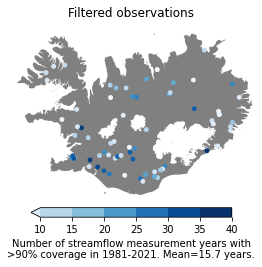

In [33]:
# Filtered observations:
merged_dff_to_plot = merged_dff[merged_dff['year_count'] > 2]

fig,ax = plt.subplots()
# Plot basemap, glaciers and set fig aesthetics
plot_figs(bmap,glaciers,ax,iceland_shapefile_color,glaciers_color)

im=merged_dff_to_plot.plot(column='year_count', s=15, 
               legend=True, legend_kwds={'label': "Number of streamflow measurement years with\n>90%% coverage in 1981-2021. Mean=%0.1f years." % merged_dff_to_plot['year_count'].mean(),
                                         'orientation': "horizontal",
                                         'shrink': 0.6, 'pad':0.03, 'boundaries':[5,10,15,20,25,30,35,40],'extend':'min'},
               ax=ax, cmap='Blues') #'hot_r')

savestr = 'data_availability_map_filtered_data%s.png' % today_str
plt.title('Filtered observations')
plt.savefig(savepath/savestr,dpi=300,bbox_inches='tight')

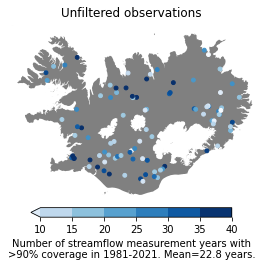

In [34]:
# Uniltered observations:
merged_dff_to_plot = merged_dff[merged_dff['year_count_unfilt'] > 2]

fig,ax = plt.subplots()
# Plot basemap, glaciers and set fig aesthetics
plot_figs(bmap,glaciers,ax,iceland_shapefile_color,glaciers_color)

im=merged_dff_to_plot.plot(column='year_count_unfilt',s=15, 
               legend=True, legend_kwds={'label': "Number of streamflow measurement years with\n>90%% coverage in 1981-2021. Mean=%0.1f years." % merged_dff_to_plot['year_count_unfilt'].mean(),
                                         'orientation': "horizontal",
                                         'shrink': 0.6, 'pad':0.03, 'boundaries':[5,10,15,20,25,30,35,40],'extend':'min'},
               ax=ax, cmap='Blues') #'hot_r')

savestr = 'data_availability_map_unfiltered_data%s.png' % today_str
plt.title('Unfiltered observations')
plt.savefig(savepath/savestr,dpi=300,bbox_inches='tight')

In [120]:
len(merged_dff[merged_dff['year_count_unfilt'] > 2])

93

In [36]:
# Now we turn on seaborn effects
import seaborn as sns
sns.set()

# Water balance plots:

<ipython-input-41-fa27807d5ded>:74: RuntimeWarning: divide by zero encountered in true_divide
  budyko_curve_y = np.power((budyko_curve_x*np.tanh(1/budyko_curve_x)*(1-np.exp(-budyko_curve_x))),0.5)
C:\Users\hordurbhe\AppData\Local\anaconda3_\envs\kiwis_old\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\hordurbhe\AppData\Local\anaconda3_\envs\kiwis_old\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\hordurbhe\AppData\Local\anaconda3_\envs\kiwis_old\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarnin

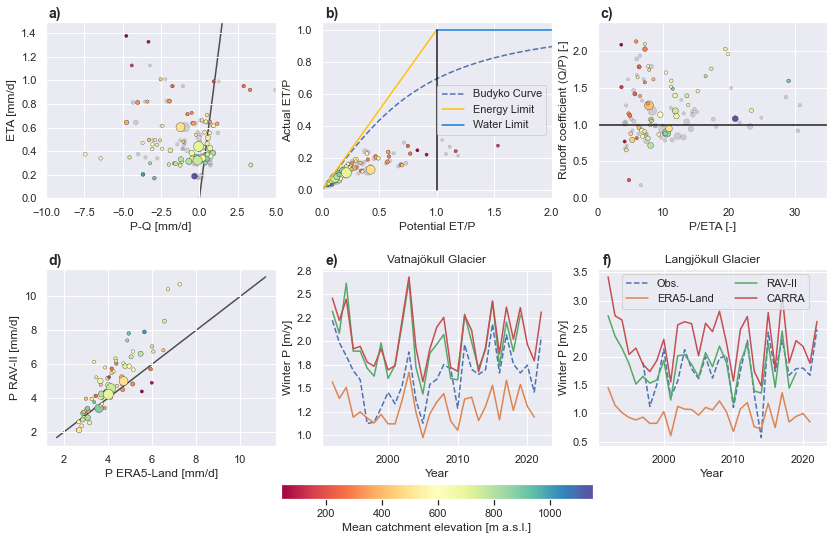

In [41]:
# July20th export:
# The final version includes precip data from RAV greyed out.
# create six subplots in a 2x3 grid
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(14,10))
# A) Water Balance Plots
ax = axs[0,0]

# Add RAV-II points, greyed out:
x = merged_dff['P_rav'].where(merged_dff['Degree']!='s') - merged_dff['Value mm'].where(merged_dff['Degree']!='s')
y = merged_dff['ET'].where(merged_dff['Degree']!='s') #valid_eta_arr
s = merged_dff['area_calc'].where(merged_dff['Degree']!='s') # assign 'area_calc' column to s parameter
c = merged_dff['elev_mean'].where(merged_dff['Degree']!='s')

# scale the values in the 'area_calc' column to a range between 10 and 500
scaler = MinMaxScaler(feature_range=(10, 100))
s_scaled = scaler.fit_transform(s.values.reshape(-1, 1)).flatten()

ax.scatter(x, y, s=s_scaled, c='grey',edgecolor='k', linewidths=0.3, label='RAV-II',alpha=0.3)

# x = merged_dff['P'].where(merged_dff['Degree']!='s') - merged_dff['Value mm'].where(merged_dff['Degree']!='s')
# y = merged_dff['ET'].where(merged_dff['Degree']!='s') #valid_eta_arr
x = merged_dff['P'] - merged_dff['Value mm']
y = merged_dff['ET'] #valid_eta_arr
s = merged_dff['area_calc'] # assign 'area_calc' column to s parameter
c = merged_dff['elev_mean']

# scale the values in the 'area_calc' column to a range between 10 and 500
scaler = MinMaxScaler(feature_range=(10, 100))
s_scaled = scaler.fit_transform(s.values.reshape(-1, 1)).flatten()

ax.scatter(x, y, s=s_scaled, c=c, cmap='Spectral',edgecolor='k', linewidths=0.3, label='ERA5-Land')

# add colorbar
ax.set_xlim([-10,5])
ax.minorticks_on()
# plt.title('Water balance analysis. Filtered obs., min coverage=95%')
ax.set_ylabel('ETA [mm/d]')
ax.set_xlabel('P-Q [mm/d]')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0,label='1:1 line')
ax.set_xlim([-10,5])
ax.set_ylim([0,1.5])


# B) Budyko plot
ax = axs[0,1]
# Calculate Budyko values for RAV-II and plot
bud_y = merged_dff['ET'] / merged_dff['P_rav']
bud_x = merged_dff['PET'] / merged_dff['P_rav']
s = merged_dff['area_calc'] # assign 'area_calc' column to s parameter
# scale the values in the 'area_calc' column to a range between 10 and 500
scaler = MinMaxScaler(feature_range=(10, 100))
s_scaled = scaler.fit_transform(s.values.reshape(-1, 1)).flatten()
ax.scatter(bud_x, bud_y, s=s_scaled, c='grey', cmap='Spectral',edgecolor='k', linewidths=0.3,label='_nolegend_',alpha=0.3)#, label='ERA5-Land')

# Calculate Budyko values for ERA5-Land
bud_y = merged_dff['ET'] / merged_dff['P']
bud_x = merged_dff['PET'] / merged_dff['P']

budyko_curve_x = np.arange(0, 4, 0.05)
energy_limit_x = np.arange(0, 1.0001, 0.05)
x = np.arange(0, 1.0001, 0.05)
budyko_curve_y = np.power((budyko_curve_x*np.tanh(1/budyko_curve_x)*(1-np.exp(-budyko_curve_x))),0.5)
water_limit_y = 1+budyko_curve_x*0
energy_limit_y = energy_limit_x
y = 1 + x*0

ax.plot(budyko_curve_x,budyko_curve_y,  linestyle='--') #,c='k')
ax.plot(energy_limit_y,energy_limit_x, c='#FFC20A') #c='y')
ax.plot(budyko_curve_x[20:],water_limit_y[20:],c='#0C7BDC') #,c='b',alpha=0.5)
ax.plot(y,x,linestyle='-', c='k',label='_nolegend_')

ax.scatter(bud_x, bud_y, s=s_scaled, c=c, cmap='Spectral',edgecolor='k', linewidths=0.3,label=False)#, label='ERA5-Land')

ax.set_ylabel("Actual ET/P")
ax.set_xlabel("Potential ET/P")
ax.set_xlim([0,2])

ax.legend(["Budyko Curve","Energy Limit", "Water Limit"])#,"LamaH-Ice"]) #,"LamaH-CE"])

# C) Runoff coefficient vs. precip
ax = axs[0,2]
ax.plot([0,40], [1,1], 'k-', zorder=1)#,label='1:1 line')

# First we plot RAV-II greyed out
x = merged_dff['P_rav'].where(merged_dff['Degree']!='s') / merged_dff['ET'].where(merged_dff['Degree']!='s')
y = merged_dff['Value mm'].where(merged_dff['Degree']!='s')/merged_dff['P_rav'].where(merged_dff['Degree']!='s')
ax.scatter(x, y, s=s_scaled, c='grey',edgecolor='k', linewidths=0.3, label='ERA5-Land',alpha=0.3)

x = merged_dff['P'].where(merged_dff['Degree']!='s') / merged_dff['ET'].where(merged_dff['Degree']!='s')
y = merged_dff['Value mm'].where(merged_dff['Degree']!='s')/merged_dff['P'].where(merged_dff['Degree']!='s')
ax.scatter(x, y, s=s_scaled, c=c, cmap='Spectral',edgecolor='k', linewidths=0.3, label='ERA5-Land')

ax.set_ylabel("Runoff coefficient (Q/P) [-]")
ax.set_xlabel("P/ETA [-]")
ax.set_ylim([0,2.4])
ax.set_xlim([0,35])

# D) RAV-II vs. ERA5-Land
ax = axs[1,0] 
im=ax.scatter(merged_dff['P'],merged_dff['P_rav'],s=s_scaled, c=c, cmap='Spectral',edgecolor='k', linewidths=0.3)
ax.set_ylabel("P RAV-II [mm/d]")
ax.set_xlabel("P ERA5-Land [mm/d]")

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)#,label='1:1 line')


# E) Precip vs. observed winter snow accumulation on Vatnajökull
ax = axs[1,1] 
startyear = 1992
endyear = 2021
era_df = pds.DataFrame(data=np.array(vatna_list),index=range(1992,2022))
rav_df = pds.DataFrame(data=np.array(vatna_list_rav),index=range(1992,2020))
carra_df = pds.DataFrame(data=np.array(vatna_list_carra),index=range(1992,2023))

obs_mean = ds_vatna.bw.mean(dim=['x','y'])
df_obs = pds.DataFrame(data=obs_mean.values, index=[int(x) for x in obs_mean.to_dataframe().index])
(df_obs).plot(ls='--',ax=ax,legend=False)
(era_df/1000).plot(ax=ax,legend=False)
(rav_df/1000).plot(ax=ax,legend=False)
(carra_df/1000).plot(ax=ax,legend=False)
ax.set_ylabel('Winter P [m/y]')
ax.set_title('Vatnajökull Glacier')

# create a formatter object with 2 decimal places
fmt = '%.1f'
y_formatter = ticker.FormatStrFormatter(fmt)

# apply the formatter to the y-axis ticks
ax.yaxis.set_major_formatter(y_formatter)
ax.set_xlabel('Year')


# F) Precip vs. observed winter snow accumulation on Langjökull
ax = axs[1,2] 
startyear = 1992
endyear = 2021
era_df = pds.DataFrame(data=np.array(lang_list),index=range(1992,2022))
rav_df = pds.DataFrame(data=np.array(lang_list_rav),index=range(1992,2020))
carra_df = pds.DataFrame(data=np.array(lang_list_carra),index=range(1992,2023))

obs_mean = ds_lang.bw.mean(dim=['x','y'])
df_obs = pds.DataFrame(data=obs_mean.values, index=[int(x) for x in obs_mean.to_dataframe().index])
(df_obs).plot(ls='--',ax=ax)
(era_df/1000).plot(ax=ax)
(rav_df/1000).plot(ax=ax)
(carra_df/1000).plot(ax=ax,legend=False)

ax.legend(labels=['Obs.','ERA5-Land','RAV-II','CARRA'], loc='upper left', ncol=2, bbox_to_anchor=(0.08, 1.0))

ax.set_ylabel('Winter P [m/y]')
ax.set_xlabel('Year')
ax.set_title('Langjökull Glacier')

# add labels to each subplot
fig.text(0.14, 0.9, "a)", fontsize=14, fontweight='bold', va='top', ha='right')
fig.text(0.415, 0.9, "b)", fontsize=14, fontweight='bold', va='top', ha='right')
fig.text(0.687, 0.9, "c)", fontsize=14, fontweight='bold', va='top', ha='right')
fig.text(0.14, 0.557, "d)", fontsize=14, fontweight='bold', va='top', ha='right')
fig.text(0.415, 0.557, "e)", fontsize=14, fontweight='bold', va='top', ha='right')
fig.text(0.687, 0.557, "f)", fontsize=14, fontweight='bold', va='top', ha='right')

# adjust spacing between subplots to prevent labels from overlapping with titles
fig.subplots_adjust(hspace=0.4)
# add a colorbar that is shared among all subplots
cbar = fig.colorbar(im, ax=axs, shrink=0.4,orientation='horizontal',pad=0.07)
cbar.set_label('Mean catchment elevation [m a.s.l.]')#, rotation=270)

# Save the plot
savestr = 'water_balance_plots__%s.png' % today_str
plt.savefig(savepath/savestr,dpi=300,bbox_inches='tight')

In [37]:
# Difference between ERA5-Land precip and discharge:
x_era = merged_dff['P'].where(merged_dff['Degree']!='s')[merged_dff['glac_fra'].where(merged_dff['Degree']!='s')<0.05] - merged_dff['Value mm'].where(merged_dff['Degree']!='s')[merged_dff['glac_fra'].where(merged_dff['Degree']!='s')<0.05]
x_rav = merged_dff['P_rav'].where(merged_dff['Degree']!='s')[merged_dff['glac_fra'].where(merged_dff['Degree']!='s')<0.05] - merged_dff['Value mm'].where(merged_dff['Degree']!='s')[merged_dff['glac_fra'].where(merged_dff['Degree']!='s')<0.05]
P_minus_Q_era = (merged_dff['P'].where(merged_dff['Degree']!='s') - merged_dff['Value mm'].where(merged_dff['Degree']!='s')).mean()
P_minus_Q_rav = (merged_dff['P_rav'].where(merged_dff['Degree']!='s') - merged_dff['Value mm'].where(merged_dff['Degree']!='s')).mean()
nbasins_glac = len(merged_dff['glac_fra'][merged_dff['glac_fra']>0.05])

print('Difference between ERA5-Land precip and obs. discharge: %.2f mm/d' %P_minus_Q_era)
print('Difference between Rav precip and obs. discharge: %.2f mm/d' %P_minus_Q_rav)
print('P_era - obs. discharge where glaciated basins have been omitted: %.2f mm/d' % x_era.mean())
print('P_rav - obs. discharge where glaciated basins have been omitted: %.2f mm/d' % x_rav.mean())
print('The number of basins with more than 5%% glaciation is %s' %nbasins_glac)

print('The number of basins with Q/P > 1 using ERA5-L precip is %s' % len(merged_dff['runoff_ratio'][merged_dff['runoff_ratio']>1]))

rav_roff_ratio = merged_dff['Value mm'] / merged_dff['P_rav']
print('The number of basins with Q/P > 1 using RAV-II precip is %s' % len(rav_roff_ratio[rav_roff_ratio>1]))



Difference between ERA5-Land precip and obs. discharge: -1.43 mm/d
Difference between Rav precip and obs. discharge: -0.62 mm/d
P_era - obs. discharge where glaciated basins have been omitted: -1.23 mm/d
P_rav - obs. discharge where glaciated basins have been omitted: -0.62 mm/d
The number of basins with more than 5% glaciation is 47
The number of basins with Q/P > 1 using ERA5-L precip is 46
The number of basins with Q/P > 1 using RAV-II precip is 38


In [102]:
len(rav_roff_ratio.dropna())

69

In [103]:
rav_roff_ratio.mean()

1.1475263860233347

In [104]:
merged_dff['runoff_ratio'].mean()

1.3004233638008034

# Now: Unfiltered data

<ipython-input-42-9991be320990>:71: RuntimeWarning: divide by zero encountered in true_divide
  budyko_curve_y = np.power((budyko_curve_x*np.tanh(1/budyko_curve_x)*(1-np.exp(-budyko_curve_x))),0.5)
C:\Users\hordurbhe\AppData\Local\anaconda3_\envs\kiwis_old\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\hordurbhe\AppData\Local\anaconda3_\envs\kiwis_old\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\hordurbhe\AppData\Local\anaconda3_\envs\kiwis_old\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarnin

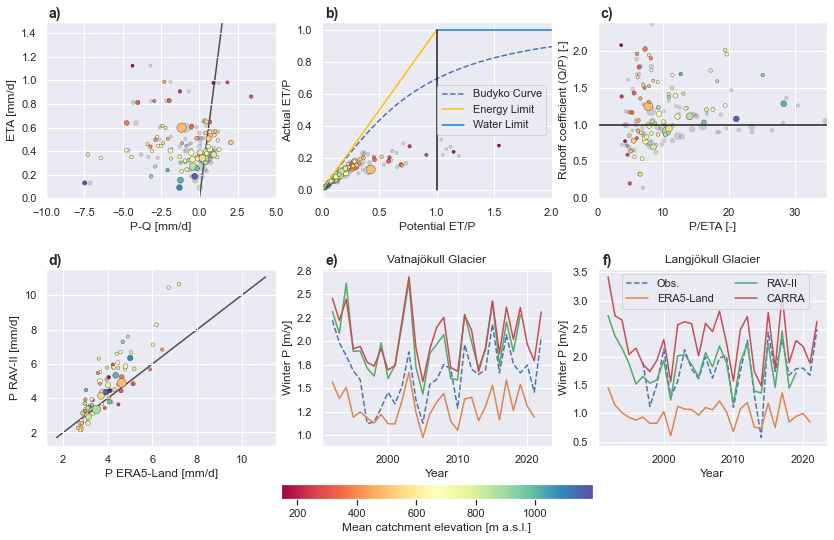

In [42]:
# The final version includes precip data from RAV greyed out.
# create six subplots in a 2x3 grid
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(14,10))
# A) Water Balance Plots
ax = axs[0,0]

# Add RAV-II points, greyed out:
x = merged_dff['P_rav_unfilt'].where(merged_dff['Degree']!='s') - merged_dff['Value mm_unfilt'].where(merged_dff['Degree']!='s')
y = merged_dff['ET_unfilt'].where(merged_dff['Degree']!='s') #valid_eta_arr
s = merged_dff['area_calc'].where(merged_dff['Degree']!='s') # assign 'area_calc' column to s parameter
c = merged_dff['elev_mean'].where(merged_dff['Degree']!='s')

# scale the values in the 'area_calc' column to a range between 10 and 500
scaler = MinMaxScaler(feature_range=(10, 100))
s_scaled = scaler.fit_transform(s.values.reshape(-1, 1)).flatten()

ax.scatter(x, y, s=s_scaled, c='grey',edgecolor='k', linewidths=0.3, label='RAV-II',alpha=0.3)

x = merged_dff['P_unfilt'].where(merged_dff['Degree']!='s') - merged_dff['Value mm_unfilt'].where(merged_dff['Degree']!='s')
y = merged_dff['ET_unfilt'].where(merged_dff['Degree']!='s') #valid_eta_arr
s = merged_dff['area_calc'].where(merged_dff['Degree']!='s') # assign 'area_calc' column to s parameter
c = merged_dff['elev_mean'].where(merged_dff['Degree']!='s')

# scale the values in the 'area_calc' column to a range between 10 and 500
scaler = MinMaxScaler(feature_range=(10, 100))
s_scaled = scaler.fit_transform(s.values.reshape(-1, 1)).flatten()

ax.scatter(x, y, s=s_scaled, c=c, cmap='Spectral',edgecolor='k', linewidths=0.3, label='ERA5-Land')

ax.set_xlim([-10,5])
ax.minorticks_on()
ax.set_ylabel('ETA [mm/d]')
ax.set_xlabel('P-Q [mm/d]')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0,label='1:1 line')
ax.set_xlim([-10,5])
ax.set_ylim([0,1.5])


# B) Budyko plot
ax = axs[0,1]
# Calculate Budyko values for RAV-II and plot
bud_y = merged_dff['ET_unfilt'] / merged_dff['P_rav_unfilt']
bud_x = merged_dff['PET_unfilt'] / merged_dff['P_rav_unfilt']
s = merged_dff['area_calc'] # assign 'area_calc' column to s parameter
# scale the values in the 'area_calc' column to a range between 10 and 500
scaler = MinMaxScaler(feature_range=(10, 100))
s_scaled = scaler.fit_transform(s.values.reshape(-1, 1)).flatten()
ax.scatter(bud_x, bud_y, s=s_scaled, c='grey', cmap='Spectral',edgecolor='k', linewidths=0.3,label='_nolegend_',alpha=0.3)#, label='ERA5-Land')


# Calculate Budyko values for ERA5-Land
bud_y = merged_dff['ET_unfilt'] / merged_dff['P_unfilt']
bud_x = merged_dff['PET_unfilt'] / merged_dff['P_unfilt']

budyko_curve_x = np.arange(0, 4, 0.05)
energy_limit_x = np.arange(0, 1.0001, 0.05)
x = np.arange(0, 1.0001, 0.05)
budyko_curve_y = np.power((budyko_curve_x*np.tanh(1/budyko_curve_x)*(1-np.exp(-budyko_curve_x))),0.5)
water_limit_y = 1+budyko_curve_x*0
energy_limit_y = energy_limit_x
y = 1 + x*0

ax.plot(budyko_curve_x,budyko_curve_y,  linestyle='--') #,c='k')
ax.plot(energy_limit_y,energy_limit_x, c='#FFC20A') #c='y')
ax.plot(budyko_curve_x[20:],water_limit_y[20:],c='#0C7BDC') #,c='b',alpha=0.5)
ax.plot(y,x,linestyle='-', c='k',label='_nolegend_')

ax.scatter(bud_x, bud_y, s=s_scaled, c=c, cmap='Spectral',edgecolor='k', linewidths=0.3,label=False)#, label='ERA5-Land')

ax.set_ylabel("Actual ET/P")
ax.set_xlabel("Potential ET/P")
ax.set_xlim([0,2])
ax.legend(["Budyko Curve","Energy Limit", "Water Limit"])#,"LamaH-Ice"]) #,"LamaH-CE"])

# C) Runoff coefficient vs. precip
ax = axs[0,2]
ax.plot([0,40], [1,1], 'k-', zorder=1)#,label='1:1 line')

# First we plot RAV-II greyed out
x = merged_dff['P_rav_unfilt'].where(merged_dff['Degree']!='s') / merged_dff['ET_unfilt'].where(merged_dff['Degree']!='s')
y = merged_dff['Value mm_unfilt'].where(merged_dff['Degree']!='s')/merged_dff['P_rav_unfilt'].where(merged_dff['Degree']!='s')
ax.scatter(x, y, s=s_scaled, c='grey',edgecolor='k', linewidths=0.3, label='ERA5-Land',alpha=0.3)

x = merged_dff['P_unfilt'].where(merged_dff['Degree']!='s') / merged_dff['ET_unfilt'].where(merged_dff['Degree']!='s')
y = merged_dff['Value mm_unfilt'].where(merged_dff['Degree']!='s')/merged_dff['P_unfilt'].where(merged_dff['Degree']!='s')
ax.scatter(x, y, s=s_scaled, c=c, cmap='Spectral',edgecolor='k', linewidths=0.3, label='ERA5-Land')

ax.set_ylabel("Runoff coefficient (Q/P) [-]")
ax.set_xlabel("P/ETA [-]")
ax.set_ylim([0,2.4])
ax.set_xlim([0,35])

# D) RAV-II vs. ERA5-Land
ax = axs[1,0] 
im=ax.scatter(merged_dff['P_unfilt'],merged_dff['P_rav_unfilt'],s=s_scaled, c=c, cmap='Spectral',edgecolor='k', linewidths=0.3)
ax.set_ylabel("P RAV-II [mm/d]")
ax.set_xlabel("P ERA5-Land [mm/d]")

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)#,label='1:1 line')


# E) Precip vs. observed winter snow accumulation on Vatnajökull
ax = axs[1,1] 
startyear = 1992
endyear = 2021
era_df = pds.DataFrame(data=np.array(vatna_list),index=range(1992,2022))
rav_df = pds.DataFrame(data=np.array(vatna_list_rav),index=range(1992,2020))
carra_df = pds.DataFrame(data=np.array(vatna_list_carra),index=range(1992,2023))

obs_mean = ds_vatna.bw.mean(dim=['x','y'])
df_obs = pds.DataFrame(data=obs_mean.values, index=[int(x) for x in obs_mean.to_dataframe().index])
(df_obs).plot(ls='--',ax=ax,legend=False)
(era_df/1000).plot(ax=ax,legend=False)
(rav_df/1000).plot(ax=ax,legend=False)
(carra_df/1000).plot(ax=ax,legend=False)
ax.set_ylabel('Winter P [m/y]')
ax.set_title('Vatnajökull Glacier')

# create a formatter object with 2 decimal places
fmt = '%.1f'
y_formatter = ticker.FormatStrFormatter(fmt)

# apply the formatter to the y-axis ticks
ax.yaxis.set_major_formatter(y_formatter)
ax.set_xlabel('Year')


# F) Precip vs. observed winter snow accumulation on Langjökull
ax = axs[1,2] 
startyear = 1992
endyear = 2021
era_df = pds.DataFrame(data=np.array(lang_list),index=range(1992,2022))
rav_df = pds.DataFrame(data=np.array(lang_list_rav),index=range(1992,2020))
carra_df = pds.DataFrame(data=np.array(lang_list_carra),index=range(1992,2023))

obs_mean = ds_lang.bw.mean(dim=['x','y'])
df_obs = pds.DataFrame(data=obs_mean.values, index=[int(x) for x in obs_mean.to_dataframe().index])
(df_obs).plot(ls='--',ax=ax)
(era_df/1000).plot(ax=ax)
(rav_df/1000).plot(ax=ax)
(carra_df/1000).plot(ax=ax,legend=False)

ax.legend(labels=['Obs.','ERA5-Land','RAV-II','CARRA'], loc='upper left', ncol=2, bbox_to_anchor=(0.08, 1.0))
ax.set_ylabel('Winter P [m/y]')
ax.set_xlabel('Year')
ax.set_title('Langjökull Glacier')

# add labels to each subplot
fig.text(0.14, 0.9, "a)", fontsize=14, fontweight='bold', va='top', ha='right')
fig.text(0.415, 0.9, "b)", fontsize=14, fontweight='bold', va='top', ha='right')
fig.text(0.687, 0.9, "c)", fontsize=14, fontweight='bold', va='top', ha='right')
fig.text(0.14, 0.557, "d)", fontsize=14, fontweight='bold', va='top', ha='right')
fig.text(0.415, 0.557, "e)", fontsize=14, fontweight='bold', va='top', ha='right')
fig.text(0.687, 0.557, "f)", fontsize=14, fontweight='bold', va='top', ha='right')

# adjust spacing between subplots to prevent labels from overlapping with titles
fig.subplots_adjust(hspace=0.4)
# add a colorbar that is shared among all subplots
cbar = fig.colorbar(im, ax=axs, shrink=0.4,orientation='horizontal',pad=0.07)
cbar.set_label('Mean catchment elevation [m a.s.l.]')#, rotation=270)

# Save the plot
savestr = 'water_balance_plots_unfilt_%s.png' % today_str
plt.savefig(savepath/savestr,dpi=300,bbox_inches='tight')

In [43]:
# Print stats mentioned in the paper:
glac_f = 0.05
x_era = merged_dff['P_unfilt'].where(merged_dff['Degree']!='s')[merged_dff['glac_fra'].where(merged_dff['Degree']!='s')<glac_f] - merged_dff['Value mm_unfilt'].where(merged_dff['Degree']!='s')[merged_dff['glac_fra'].where(merged_dff['Degree']!='s')<glac_f]
x_rav = merged_dff['P_rav_unfilt'].where(merged_dff['Degree']!='s')[merged_dff['glac_fra'].where(merged_dff['Degree']!='s')<glac_f] - merged_dff['Value mm_unfilt'].where(merged_dff['Degree']!='s')[merged_dff['glac_fra'].where(merged_dff['Degree']!='s')<glac_f]
P_minus_Q_era = (merged_dff['P_unfilt'].where(merged_dff['Degree']!='s') - merged_dff['Value mm_unfilt'].where(merged_dff['Degree']!='s')).mean()
P_minus_Q_rav = (merged_dff['P_rav_unfilt'].where(merged_dff['Degree']!='s') - merged_dff['Value mm_unfilt'].where(merged_dff['Degree']!='s')).mean()

print('Difference between ERA5-Land precip and obs. discharge: %.2f mm/d' %P_minus_Q_era)
print('Difference between Rav precip and obs. discharge: %.2f mm/d' %P_minus_Q_rav)
print('P_era - obs. discharge where glaciated basins have been omitted: %.2f mm/d' % x_era.mean())
print('P_rav - obs. discharge where glaciated basins have been omitted: %.2f mm/d' % x_rav.mean())

Difference between ERA5-Land precip and obs. discharge: -1.16 mm/d
Difference between Rav precip and obs. discharge: -0.47 mm/d
P_era - obs. discharge where glaciated basins have been omitted: -0.83 mm/d
P_rav - obs. discharge where glaciated basins have been omitted: -0.33 mm/d


# 5.1 Topographic indices

In [59]:
# Read the latest version of the watersheds polygons
latest_wsheds = gpds.read_file(Path(r'C:\Users\hordurbhe\Dropbox\UW\lamah_ice\GIS\watersheds\final_watersheds\final_watersheds\Basins_A.shp'))
latest_wsheds = latest_wsheds.set_index('id')

latest_wsheds_area = latest_wsheds.geometry.area/1e6 #.set_index('id')
# Before calculating stats, remove the four watersheds that were altered due to diversions
latest_wsheds_area = latest_wsheds_area.drop([890,990,1010,9900])

In [61]:
area_max = latest_wsheds_area.max()
area_min = latest_wsheds_area.min()
area_median = latest_wsheds_area.median()
area_mean = latest_wsheds_area.mean()
print(area_max,area_min,area_median,area_mean)

7437.17264521241 3.8444 384.45680000000004 901.3316511685822


In [62]:
gdf = latest_wsheds.drop([890,990,1010,9900]).geometry.copy()
# Merge overlapping polygons into a single polygon
merged_polygon = gdf.geometry.unary_union

# Calculate the area of the merged polygon
area = merged_polygon.area

# Print the area
print("Total area: ", area/1e6)

Total area:  45944.72082678438


In [65]:
# Save as .shp file - For figure 1
buffer_distance = 0.1  # Adjust this value as needed

# Buffer the MultiPolygon to eliminate small holes
buffered_polygon = merged_polygon.buffer(buffer_distance, cap_style=3, join_style=2)

# Convert the buffered polygon back to a MultiPolygon
cleaned_multipolygon = MultiPolygon(buffered_polygon)
crs = from_epsg(3057)

# Create a GeoDataFrame with the cleaned MultiPolygon geometry
gdf_cleaned = gpd.GeoDataFrame(geometry=[cleaned_multipolygon], crs=crs)

# Save the cleaned GeoDataFrame to a shapefile
output_shapefile_path = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\3_shapefiles\merged_catchment_polygon_cleaned.shp")
# output_shapefile_path = 'path/to/your/output/cleaned_file.shp'
gdf_cleaned.to_file(output_shapefile_path)

# # Assuming you have your MultiPolygon object named 'merged_polygon' and the desired CRS is EPSG:3057
# crs = from_epsg(3057)

# # Create a GeoDataFrame with the MultiPolygon and assign the CRS
# gdf = gpd.GeoDataFrame(geometry=[merged_polygon], crs=crs)

# # Save the GeoDataFrame to a shapefile
# output_shapefile_path = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\3_shapefiles\merged_catchment_polygon.shp")
# gdf.to_file(output_shapefile_path)

C:\Users\hordurbhe\AppData\Local\anaconda3_\envs\kiwis_old\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [57]:
# gdf = latest_wsheds.drop([74,900,10400,1040,1010]).geometry.copy()
# # Merge overlapping polygons into a single polygon
# merged_polygon = gdf.geometry.unary_union
glacierized_portions = gpds.read_file(Path(r'C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\3_shapefiles\glaciers_in_catchments.shp'))
glacierized_portions = glacierized_portions.set_index('id').drop([990,1010,9900])
merged_glaciers = glacierized_portions.geometry.unary_union

# Calculate the area of the merged polygon
area = merged_glaciers.area

# Print the area
print("Total area: ", area/1e6)


Total area:  6201.587420495662


In [58]:
# Total glacier area in Iceland: 10,400 km2 (Hannesdóttir et al 2020)
area/10400/1e6

0.5963064827399676

# 5.2 Climate indices

In [66]:
import matplotlib
matplotlib.rc_file_defaults()

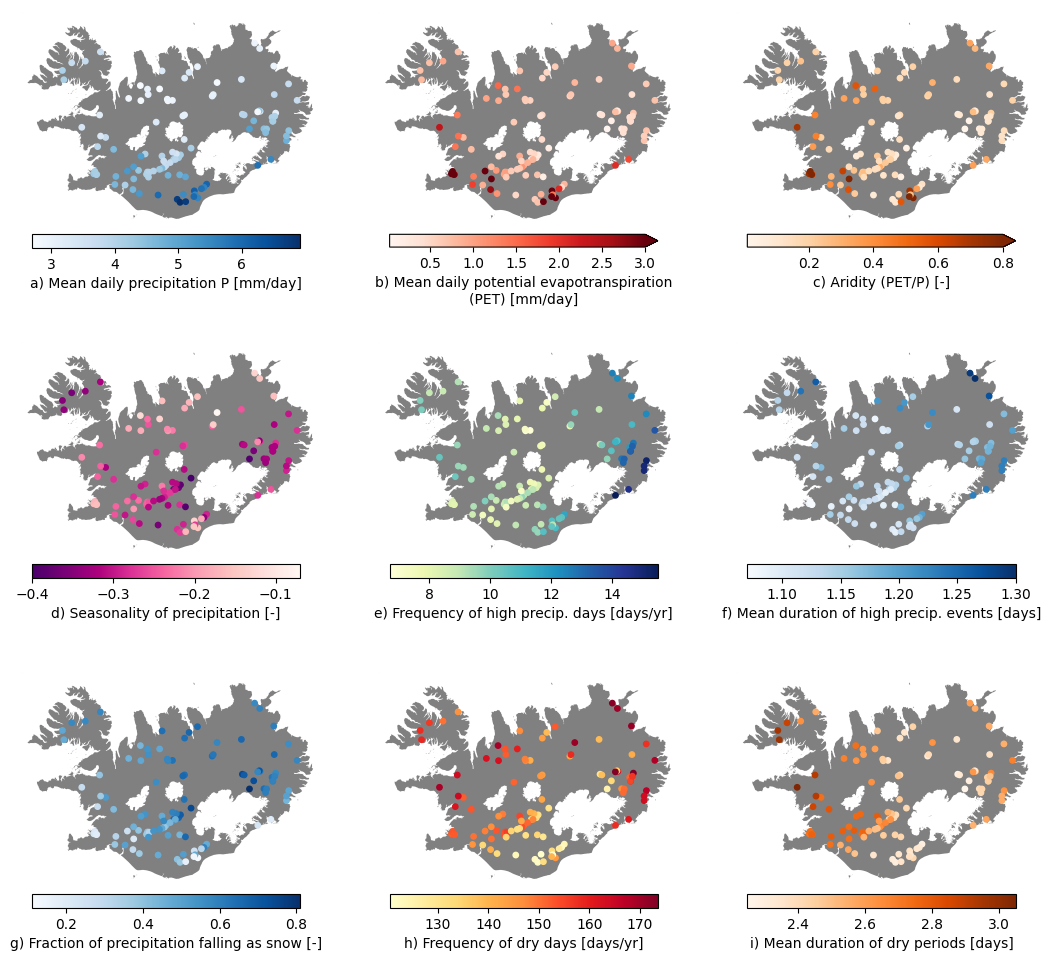

In [67]:
# climate indices
clim_cols = ["p_mean","pet_mean","aridity",
             "p_seasonality","high_prec_freq","high_prec_dur",
             "frac_snow","low_prec_freq","low_prec_dur"]
clim_txt = ["a) Mean daily precipitation P [mm/day]", "b) Mean daily potential evapotranspiration\n(PET) [mm/day]", "c) Aridity (PET/P) [-]",
            "d) Seasonality of precipitation [-]", "e) Frequency of high precip. days [days/yr]", "f) Mean duration of high precip. events [days]",
            "g) Fraction of precipitation falling as snow [-]", "h) Frequency of dry days [days/yr]", "i) Mean duration of dry periods [days]"]
clim_col_sh = ["Blues", "Reds", "Oranges",
                 "RdPu_r", "YlGnBu", "Blues",
                 "Blues", "YlOrRd", "Oranges"]
clim_col_rev = [False,False,False,
                  True,False,False,
                  False,False,False]
clim_col_br = [[2.2,2.8,3.4,4.0,4.6], [0.2,0.4,0.6,0.8,1.0], [0,0.15,0.3,0.45,0.6],
                [-0.4,-0.3,-0.2,-0.1,0], [10,12,14,16,18], [1.12,1.14,1.16,1.18,1.2],
                [0.1,0.2,0.3,0.4,0.5], [100,120,140,160,180], [1.8,2.0,2.2,2.4,2.6]]

extends = ['neither','neither','neither','neither','neither','neither','neither','neither','neither']

# define subplot grid
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

# plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(hspace=0.25, wspace=-.2) # adjust hspace and wspace -0.45

i=0
for col, ax in zip(clim_cols, axs.ravel()):
    plot_figs(bmap,glaciers,ax,iceland_shapefile_color,glaciers_color)
    
    # In the case of PET, we set the vmax as 3
    if i==1:
        im=merged_dff.plot(column=col,s=15, 
           legend=True, legend_kwds={'label': clim_txt[i],
                                     'orientation': "horizontal",
                                     'shrink': 0.6, 'pad':0.03,'extend':'max'}, ax=ax, cmap=clim_col_sh[i],vmax=3)
    
    # In the case of Aridity, we set the vmax to 0.8
    elif i==2:
        im=merged_dff.plot(column=col,s=15, 
           legend=True, legend_kwds={'label': clim_txt[i],
                                     'orientation': "horizontal",
                                     'shrink': 0.6, 'pad':0.03,'extend':'max'}, ax=ax, cmap=clim_col_sh[i],vmax=0.8)
    else:
        im=merged_dff.plot(column=col,s=15, 
           legend=True, legend_kwds={'label': clim_txt[i],
                                     'orientation': "horizontal",
                                     'shrink': 0.6, 'pad':0.03}, ax=ax, cmap=clim_col_sh[i]) 

    i+=1

savestr = 'climate_indices_plot_%s.png' % today_str
plt.savefig(savepath/savestr,dpi=300,bbox_inches='tight')

# 5.3 Hydrological signatures

In [68]:
# hydro indices
cols = ['q_mean', 'runoff_ratio', 'hfd_mean', 'slope_fdc', 'baseflow_index_ladson', 'stream_elas', 
        'high_q_freq', 'high_q_dur', 'Q95', 'low_q_freq', 'low_q_dur', 'Q5']

cols= [x+'_unfilt' for x in cols]
hydro_row = [cols.index(col) for col in ["q_mean_unfilt","runoff_ratio_unfilt","hfd_mean_unfilt",
                                          "slope_fdc_unfilt","baseflow_index_ladson_unfilt","stream_elas_unfilt",
                                          "high_q_freq_unfilt","high_q_dur_unfilt","Q95_unfilt",
                                          "low_q_freq_unfilt","low_q_dur_unfilt","Q5_unfilt"]]
hydro_txt = ["a) Mean daily discharge Q [mm/d]", "b) Runoff ratio (Q/P) [-]", "c) Mean half-flow date [days since 01. Oct.]",
             "d) Slope of the flow duration curve [-]", "e) Baseflow index [-]", "f) Discharge precipitation elasticity [-]",
             "g) High-flow frequency [days/yr]", "h) Mean high-flow duration [days]", "i) Q95 [mm/d]",
             "j) Low-flow frequency [days/yr]", "k) Mean low-flow duration [days]", "l) Q5 [mm/d]"]
hydro_col_sh = ["Blues", "YlGn", "BuGn",
                  "Oranges", "BuPu", "Reds",
                  "YlGnBu", "Blues", "Blues",
                  "YlOrRd", "Oranges", "Oranges_r"]
hydro_col_rev = [False,False,False,
                    False,False,False,
                    False,False,False,
                    False,False,True]

hydro_col_br = [[2,4,6,8,10,12], [0,0.5,1,1.5,2,2.5,3], [110,140,170,200,230,260,290], #[0,1,2,3],
                    [0,1,2,3,4,5], [0.3,0.4,0.5,0.6,0.7,0.8,0.9], [-1,1,2,3,4,5],
                    [0,5,10,15,20,25], [1,2,3,4,5,6], [0,5,10,15,20,25,30],
                    [0,20,40,60,80,100,120], [0,5,10,15,20,25,30,35], [0,2,4,6,8,10]]

vmaxs = [10,2,290,4.4,0.9,4.4,25,6,30,115,35,10]
extends = ['both','max','min','neither','max','min','max','max','max','neither','max','max']

In [69]:
index_names = ['q_mean','runoff_ratio','stream_elas',
                    'slope_fdc','baseflow_index_ladson',
                    'hfd_mean','Q5',
                    'Q95','high_q_freq','high_q_dur','low_q_freq',
                    'low_q_dur','zero_q_freq']
for col in index_names:
    print('%s, %.2f-%.2f, vs. %.2f-%.2f for unfiltered' % (col,merged_dff[col].min(),merged_dff[col].max(),merged_dff[col+'_unfilt'].min(),merged_dff[col+'_unfilt'].max()))

q_mean, 1.08-19.64, vs. 0.85-19.58 for unfiltered
runoff_ratio, 0.25-5.31, vs. 0.20-5.32 for unfiltered
stream_elas, -1.22-2.93, vs. -2.92-4.41 for unfiltered
slope_fdc, 0.23-4.91, vs. 0.23-7.10 for unfiltered
baseflow_index_ladson, 0.38-0.93, vs. 0.39-0.97 for unfiltered
hfd_mean, 128.00-274.44, vs. 149.47-297.86 for unfiltered
Q5, 0.25-16.34, vs. 0.09-16.34 for unfiltered
Q95, 2.59-31.77, vs. 2.51-31.38 for unfiltered
high_q_freq, 0.05-24.22, vs. 0.03-36.75 for unfiltered
high_q_dur, 1.00-6.36, vs. 1.00-11.09 for unfiltered
low_q_freq, 0.09-117.55, vs. 0.08-151.05 for unfiltered
low_q_dur, 1.00-22.83, vs. 1.00-40.26 for unfiltered
zero_q_freq, 0.00-0.02, vs. 0.00-0.02 for unfiltered


In [72]:
merged_dff['runoff_ratio'].where(merged_dff['Degree'] != 's').dropna().mean()

1.2980591158625885

# No we plot streamflow signatures with filtered data:

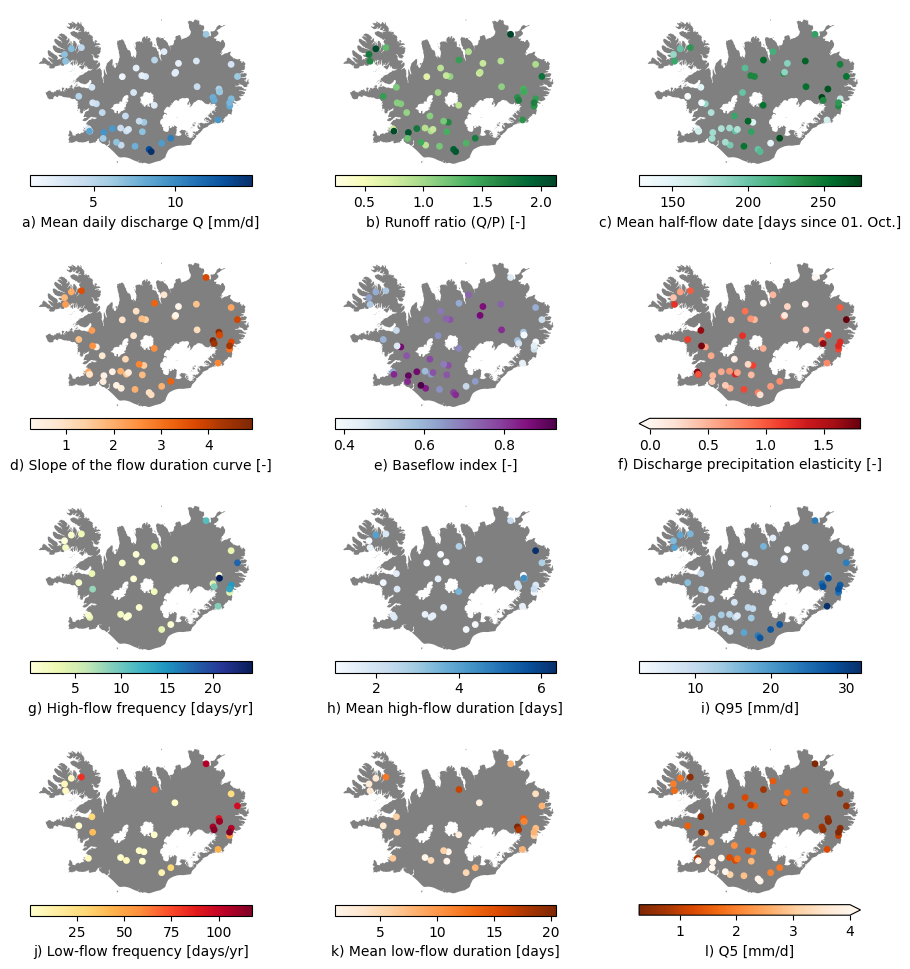

In [107]:
# hydro indices
cols = ['q_mean', 'runoff_ratio', 'hfd_mean', 'slope_fdc', 'baseflow_index_ladson', 'stream_elas', 
        'high_q_freq', 'high_q_dur', 'Q95', 'low_q_freq', 'low_q_dur', 'Q5']

hydro_row = [cols.index(col) for col in ["q_mean","runoff_ratio","hfd_mean",
                                          "slope_fdc","baseflow_index_ladson","stream_elas",
                                          "high_q_freq","high_q_dur","Q95",
                                          "low_q_freq","low_q_dur","Q5"]]
hydro_txt = ["a) Mean daily discharge Q [mm/d]", "b) Runoff ratio (Q/P) [-]", "c) Mean half-flow date [days since 01. Oct.]",
             "d) Slope of the flow duration curve [-]", "e) Baseflow index [-]", "f) Discharge precipitation elasticity [-]",
             "g) High-flow frequency [days/yr]", "h) Mean high-flow duration [days]", "i) Q95 [mm/d]",
             "j) Low-flow frequency [days/yr]", "k) Mean low-flow duration [days]", "l) Q5 [mm/d]"]
hydro_col_sh = ["Blues", "YlGn", "BuGn",
                  "Oranges", "BuPu", "Reds",
                  "YlGnBu", "Blues", "Blues",
                  "YlOrRd", "Oranges", "Oranges_r"]
hydro_col_rev = [False,False,False,
                    False,False,False,
                    False,False,False,
                    False,False,True]

hydro_col_br = [[2,4,6,8,10,12], [0,0.5,1,1.5,2,2.5,3], [110,140,170,200,230,260,290], #[0,1,2,3],
                    [0,1,2,3,4,5], [0.3,0.4,0.5,0.6,0.7,0.8,0.9], [-1,1,2,3,4,5],
                    [0,5,10,15,20,25], [1,2,3,4,5,6], [0,5,10,15,20,25,30],
                    [0,20,40,60,80,100,120], [0,5,10,15,20,25,30,35], [0,2,4,6,8,10]]

vmaxs = [10,2,290,4.4,0.9,4.4,25,6,30,115,35,10]
extends = ['both','max','min','neither','max','min','max','max','max','neither','max','max']

# define subplot grid
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))

# plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(hspace=0.25, wspace=-0.45) # adjust hspace and wspace

i=0
for col, ax in zip(cols, axs.ravel()):
    plot_figs(bmap,glaciers,ax,iceland_shapefile_color,glaciers_color)
    
    if i==5:
        # In the case of precipitation elasticity, we set the vmin as 0
        im=merged_dff.where(merged_dff['Degree'] != 's').plot(column=col,s=15, 
               legend=True, legend_kwds={'label': hydro_txt[i],
                                         'orientation': "horizontal",
                                         'shrink': 0.4, 'pad':0.03,
                                        'extend': 'min'}, 
               ax=ax, cmap=hydro_col_sh[i],vmin=0)
    elif i==11:
        # In the case of Q5, we set the vmax as 6
        im=merged_dff.where(merged_dff['Degree'] != 's').plot(column=col,s=15, 
               legend=True, legend_kwds={'label': hydro_txt[i],
                                         'orientation': "horizontal",
                                         'shrink': 0.4, 'pad':0.03,
                                        'extend': 'max'}, 
               ax=ax, cmap=hydro_col_sh[i],vmax=4)
    else:

        im=merged_dff.where(merged_dff['Degree'] != 's').plot(column=col,s=15, 
                       legend=True, legend_kwds={'label': hydro_txt[i],
                                                 'orientation': "horizontal",
                                                 'shrink': 0.4, 'pad':0.03},
                       ax=ax, cmap=hydro_col_sh[i])

    i+=1

savestr = 'streamflow_indices_plot_%s.png' % today_str
plt.savefig(savepath/savestr,dpi=300,bbox_inches='tight')

# 5.4 Land cover characteristics

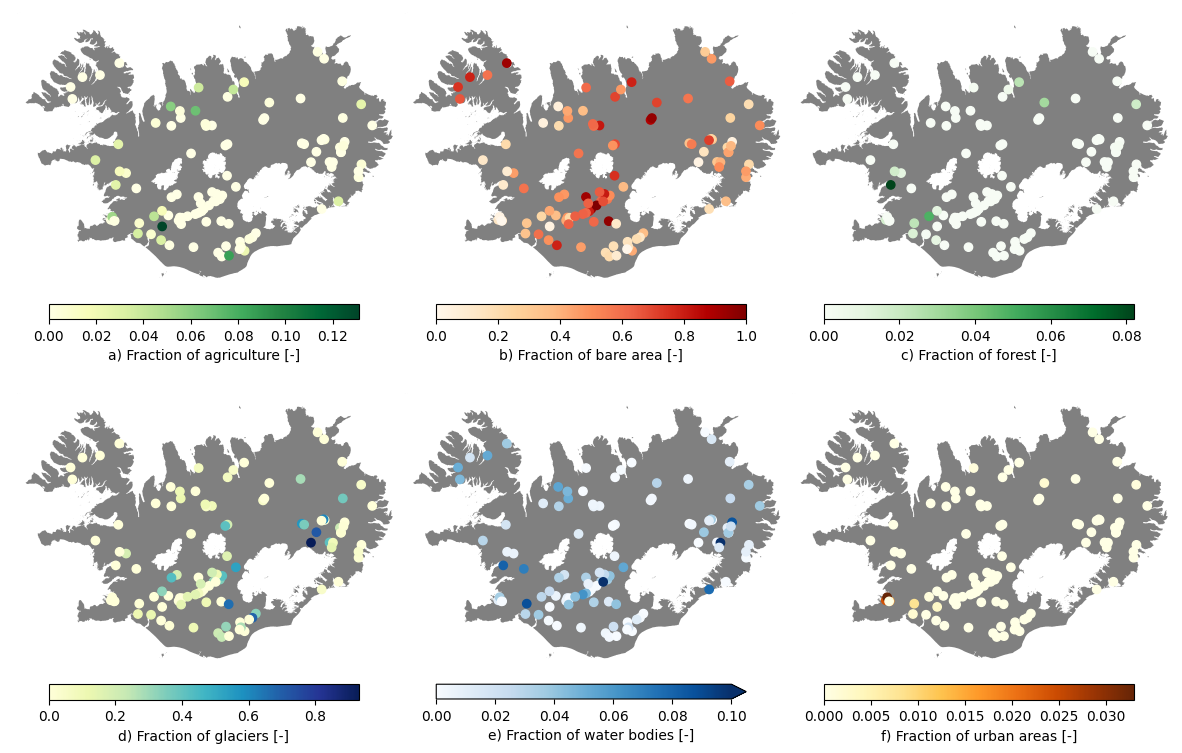

In [109]:
# landclasses
lc_cols = ["agr_fra", "bare_fra", "forest_fra", "glac_fra", "lake_fra", "urban_fra"]
lc_txt = ["a) Fraction of agriculture [-]", "b) Fraction of bare area [-]", "c) Fraction of forest [-]",
          "d) Fraction of glaciers [-]", "e) Fraction of water bodies [-]", "f) Fraction of urban areas [-]"]
lc_col_sh = ["YlGn", "OrRd", "Greens", "YlGnBu", "Blues", "YlOrBr"]
lc_col_rev = [False, False, False, False, False, False]
lc_col_br = [[0.1, 0.2, 0.4, 0.6, 0.8], [0.01, 0.05, 0.1, 0.2, 0.4], [0.1, 0.2, 0.4, 0.6, 0.8],
             [0.01, 0.02, 0.03, 0.05, 0.1], [0.01, 0.02, 0.03, 0.04, 0.05], [0.01, 0.05, 0.1, 0.15, 0.2]]

# define subplot grid
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 12))

# plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(hspace=-0.3, wspace=0)##-.2) # adjust hspace and wspace -0.45

i=0
for col, ax in zip(lc_cols, axs.ravel()):
    plot_figs(bmap,glaciers,ax,iceland_shapefile_color,glaciers_color)
    
    # In the case of lake fractions, we set the vmax as 0.2
    if i == 4:
        im=merged_dff.plot(column=col,#s=15, 
           legend=True, legend_kwds={'label': lc_txt[i],
                                     'orientation': "horizontal",
                                     'shrink': 0.8, 'pad':0.03,'extend':'max'},ax=ax, cmap=lc_col_sh[i], vmax=0.1)
        
    else:
        im=merged_dff.plot(column=col,#s=15, 
           legend=True, legend_kwds={'label': lc_txt[i],
                                     'orientation': "horizontal",
                                     'shrink': 0.8, 'pad':0.03}, ax=ax, cmap=lc_col_sh[i]) 

    i+=1

savestr = 'landcover_classes_%s.png' % today_str
plt.savefig(savepath/savestr,dpi=300,bbox_inches='tight')

In [110]:
# Print statistics about land cover classes in LamaH-Ice:
100*merged_dff[["agr_fra", "bare_fra", "forest_fra", "glac_fra", "lake_fra", "urban_fra"]].mean()

agr_fra        0.831776
bare_fra      44.229907
forest_fra     0.293458
glac_fra      12.480374
lake_fra       2.327103
urban_fra      0.085047
dtype: float64

# 5.5 Vegetation indices

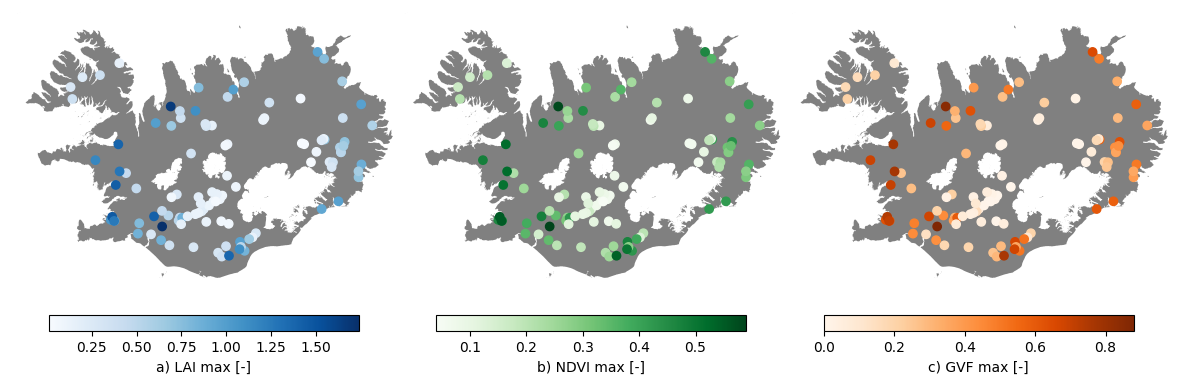

In [111]:
# Vegetation indices - Skipping the lower panel:
# Vegetation
veg_cols = ["lai_max","ndvi_max","gvf_max"]
veg_txt = ["a) LAI max [-]", "b) NDVI max [-]", "c) GVF max [-]"]
veg_col_sh = ["Blues", "Greens", "Oranges"]

# define subplot grid
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 12))

plt.subplots_adjust(hspace=-0.3, wspace=0)

i=0
for col, ax in zip(veg_cols, axs.ravel()):
    plot_figs(bmap,glaciers,ax,iceland_shapefile_color,glaciers_color)
    
    im=merged_dff.plot(column=col,#s=15, 
       legend=True, legend_kwds={'label': veg_txt[i],
                                 'orientation': "horizontal",
                                 'shrink': 0.8, 'pad':0.03}, 
       ax=ax, cmap=veg_col_sh[i])

    i+=1

savestr = 'veg_indices_plot_final_%s.png' % today_str
plt.savefig(savepath/savestr,dpi=300,bbox_inches='tight')

# 5.6 Surface deposits and soil characteristics

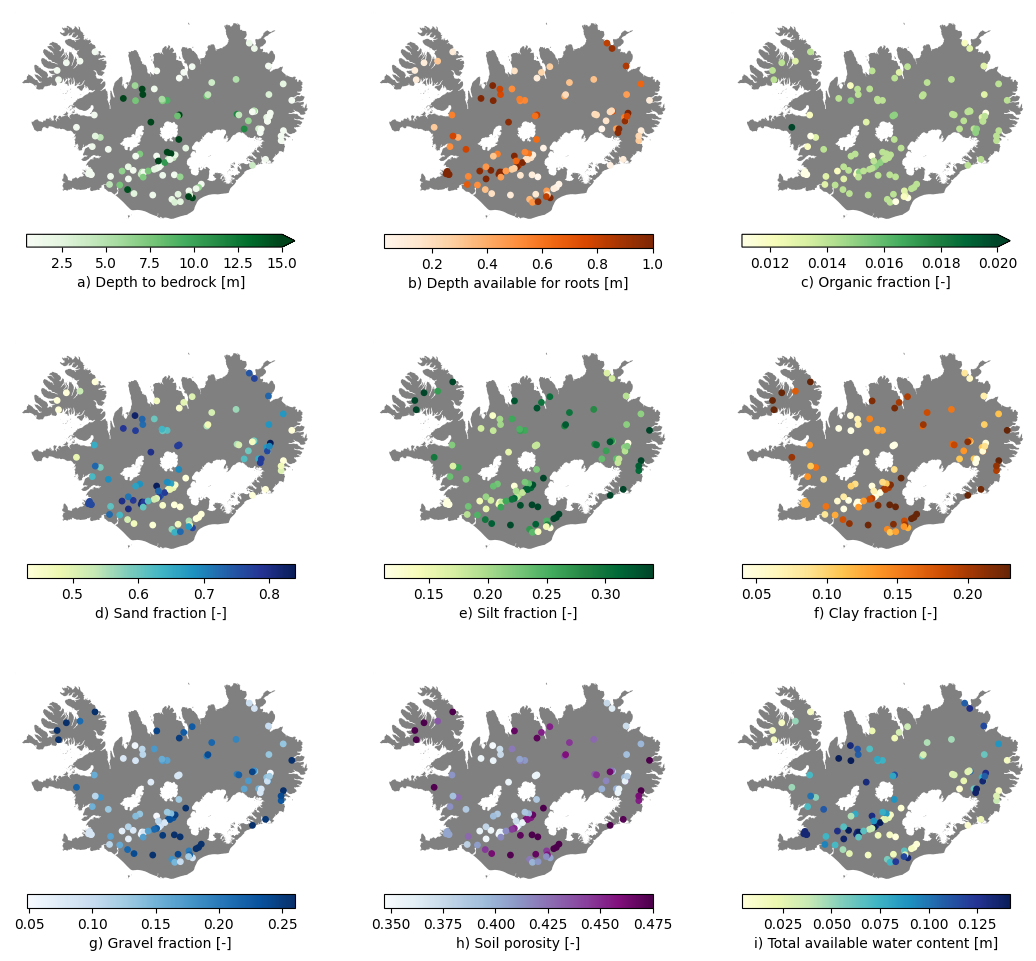

In [117]:
soil_cols = ["bedrk_dep", "root_dep", "oc_fra", "sand_fra", "silt_fra", "clay_fra",
"grav_fra", "soil_poros", "soil_tawc"]
soil_txt = ["a) Depth to bedrock [m]", "b) Depth available for roots [m]", "c) Organic fraction [-]",
"d) Sand fraction [-]", "e) Silt fraction [-]", "f) Clay fraction [-]",
"g) Gravel fraction [-]", "h) Soil porosity [-]", "i) Total available water content [m]"]
soil_col_sh = ["Greens", "Oranges", "YlGn", "YlGnBu", "YlGn", "YlOrBr", "Blues", "BuPu", "YlGnBu"]

# define subplot grid
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

# plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(hspace=0.25, wspace=-.2) # adjust hspace and wspace -0.45

i=0
for col, ax in zip(soil_cols, axs.ravel()):
    plot_figs(bmap,glaciers,ax,iceland_shapefile_color,glaciers_color)
    
    # In the case of depth to bedrock, we set the vmax as 15
    if i==0:
        
        im=merged_dff.plot(column=col,s=15, 
               legend=True, legend_kwds={'label': soil_txt[i],
                                         'orientation': "horizontal",
                                         'shrink': 0.6, 'pad':0.03,
                                        'extend': 'max'}, 
               ax=ax, cmap=soil_col_sh[i],vmax=15)
    elif i==2:
        im=merged_dff.plot(column=col,s=15, 
           legend=True, legend_kwds={'label': soil_txt[i],
                                     'orientation': "horizontal",
                                     'shrink': 0.6, 'pad':0.03,
                                    'extend': 'max'},
           ax=ax, cmap=soil_col_sh[i],vmax=0.02)
    else:
        im=merged_dff.plot(column=col,s=15, 
           legend=True, legend_kwds={'label': soil_txt[i],
                                     'orientation': "horizontal",
                                     'shrink': 0.6, 'pad':0.03},
           ax=ax, cmap=soil_col_sh[i]) 


    i+=1

savestr = 'soil_indices_plot_%s.png' % today_str
plt.savefig(savepath/savestr,dpi=300,bbox_inches='tight')

In [116]:
# Print the correlation between soil attributes
corr[soil_cols].loc[soil_cols]

,bedrk_dep,root_dep,oc_fra,sand_fra,silt_fra,clay_fra,grav_fra,soil_poros,soil_tawc
bedrk_dep,1.000000,0.229582,-0.091969,0.258139,-0.283326,-0.236192,-0.262949,-0.229284,0.238773
root_dep,0.229582,1.000000,-0.338535,0.949675,-0.944935,-0.888594,-0.951647,-0.893942,0.997311
oc_fra,-0.091969,-0.338535,1.000000,-0.331597,0.448978,0.180884,0.327864,0.229345,-0.293169
sand_fra,0.258139,0.949675,-0.331597,1.000000,-0.966949,-0.967802,-0.999133,-0.972775,0.946880
silt_fra,-0.283326,-0.944935,0.448978,-0.966949,1.000000,0.877950,0.971318,0.888310,-0.934546
clay_fra,-0.236192,-0.888594,0.180884,-0.967802,0.877950,1.000000,0.963929,0.998163,-0.897099
grav_fra,-0.262949,-0.951647,0.327864,-0.999133,0.971318,0.963929,1.000000,0.968523,-0.949334
soil_poros,-0.229284,-0.893942,0.229345,-0.972775,0.888310,0.998163,0.968523,1.000000,-0.899337
soil_tawc,0.238773,0.997311,-0.293169,0.946880,-0.934546,-0.897099,-0.949334,-0.899337,1.000000


# 5.7 Geological characteristics

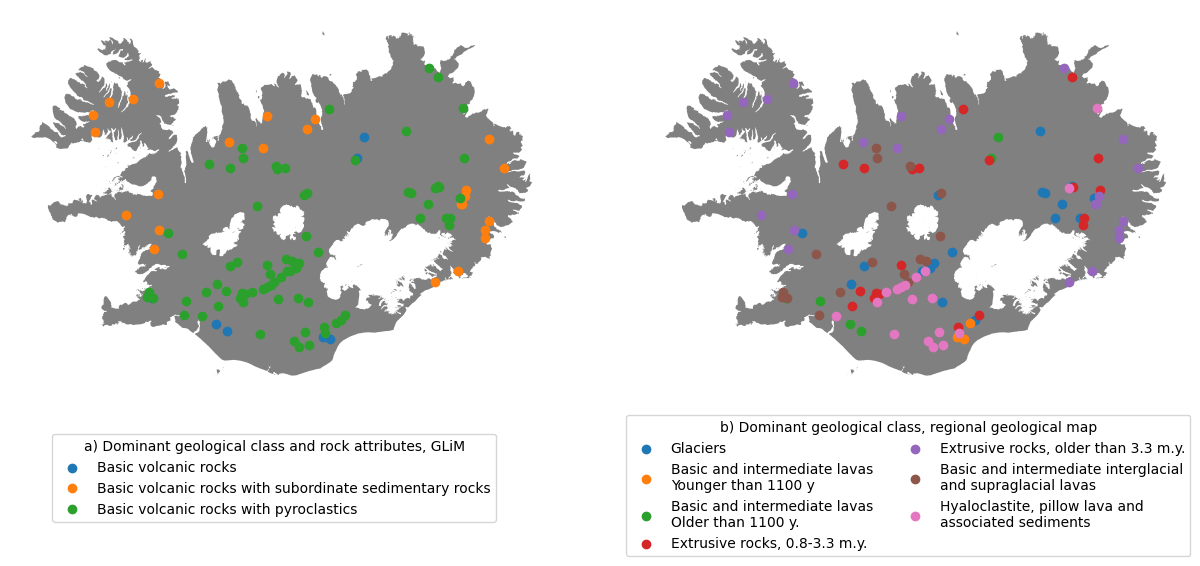

In [118]:
icelandic_geological_map_colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

# dominant geological attrs:
# gc_23_dom og g_dom_NI
g_dom_titles = dict()
g_dom_titles['621'] = 'Glaciers'
g_dom_titles['743'] = 'Lakes'
g_dom_titles['bnew'] = 'Basic and intermediate lavas\nYounger than 1100 y'
g_dom_titles['bold'] = 'Basic and intermediate lavas\nOlder than 1100 y.'
g_dom_titles['gnew'] = 'Extrusive rocks, 0.8-3.3 m.y.'
g_dom_titles['gold'] = 'Extrusive rocks, older than 3.3 m.y.'
g_dom_titles['hraun'] = 'Basic and intermediate interglacial\nand supraglacial lavas'
g_dom_titles['mob'] = 'Hyaloclastite, pillow lava and\nassociated sediments'
g_dom_titles['sgos'] = 'Acid extrusives'

g_dom_titles['vb____'] = 'Basic volcanic rocks'
g_dom_titles['vb__sr'] = 'Basic volcanic rocks with subordinate sedimentary rocks'
g_dom_titles['vbpy__'] = 'Basic volcanic rocks with pyroclastics'

geo_cols = ["gc_dom","gc_mt_fra","gc_sc_fra",
                    "gc_sm_fra","geol_poros","geol_perme","litho_dom","g_dom_NI"]
geo_txt = ["a) Dominant geologic class", "b) Fraction of metamorphics (mt) [-]", "c) Fraction of carbonate sedimentary rocks (sc) [-]",
              "d) Fraction of mixed sedimentary rocks (sm) [-]", "e) Subsurface porosity [-]", "f) Subsurface permeability [m2, log scale]"]
geo_col_sh = ["Oranges", "Oranges", "Blues",
                 "Greens", "YlGnBu", "YlGn"]

geo_cols = ["litho_dom","g_dom_NI"]

# define subplot grid
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 12))

i=0
for col, ax in zip(geo_cols, axs.ravel()):
    plot_figs(bmap,glaciers,ax,iceland_shapefile_color,glaciers_color)
    
    groups = merged_dff.groupby(col)

    j=0
    for name, group in groups:
        
        if col=='g_dom_NI':
            group.plot(ax=ax, label=g_dom_titles[name],c=icelandic_geological_map_colors[j]) #, markersize=15, marker='o')
            j+=1
        else:
            group.plot(ax=ax, label=g_dom_titles[name]) 
    if i==0:
        ax.legend(title='a) Dominant geological class and rock attributes, GLiM',loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)
    else:
        ax.legend(title='b) Dominant geological class, regional geological map',loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)


    i+=1

savestr = 'geo_classes_plot_%s.png' % today_str
plt.savefig(savepath/savestr,dpi=300,bbox_inches='tight')

# 5.9 Natural or anthropogenic impacts on runoff

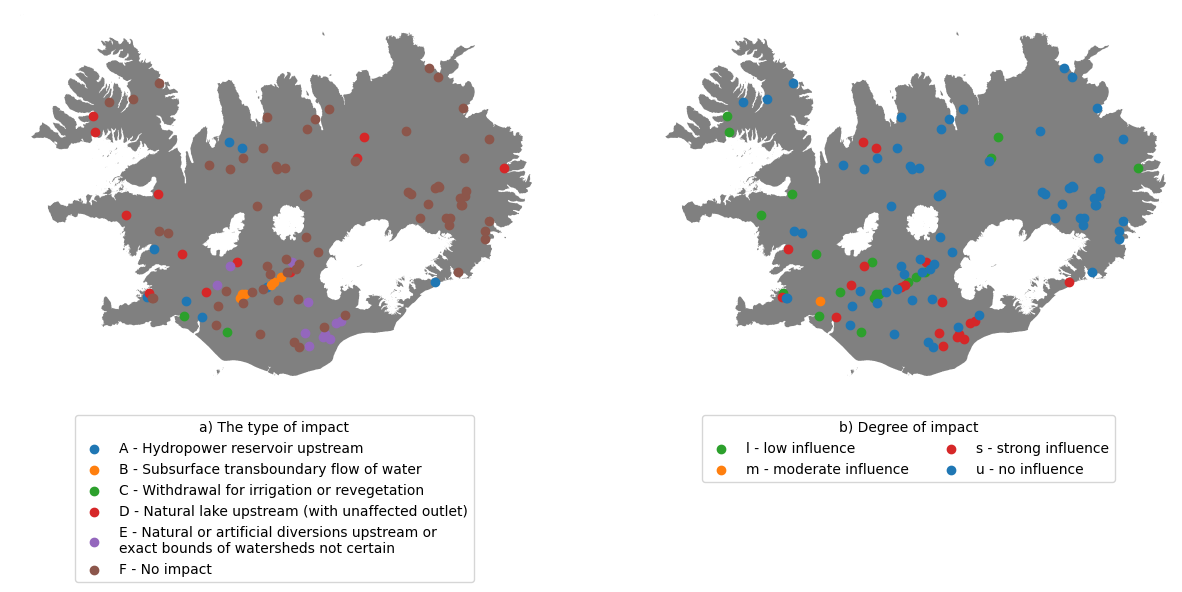

In [113]:
# Impact texts:
impact_titles = dict()
impact_titles['A'] = 'A - Hydropower reservoir upstream'
impact_titles['B'] = 'B - Subsurface transboundary flow of water'
impact_titles['C'] = 'C - Withdrawal for irrigation or revegetation'
impact_titles['D'] = 'D - Natural lake upstream (with unaffected outlet)'
impact_titles['E'] = 'E - Natural or artificial diversions upstream or\nexact bounds of watersheds not certain'
impact_titles['F'] = 'F - No impact'
impact_titles['l'] = 'l - low influence'
impact_titles['u'] = 'u - no influence'
impact_titles['s'] = 's - strong influence'
impact_titles['m'] = 'm - moderate influence'

degree_colors = ['#2ca02c','#ff7f0e','#d62728','#1f77b4']
# define subplot grid
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 12))

i=0
for col, ax in zip(['typimpact','Degree'], axs.ravel()):
    plot_figs(bmap,glaciers,ax,iceland_shapefile_color,glaciers_color)
    
    groups = merged_dff.groupby(col)

    j=0
    for name, group in groups:
        if i==1:
            group.plot(ax=ax, label=impact_titles[name],c=degree_colors[j]) #, markersize=15, marker='o')
            j+=1
        else:
            group.plot(ax=ax, label=impact_titles[name])#,c=impact_colors[j]) #, markersize=15, marker='o')
            j+=1
    if i==0:
        ax.legend(title='a) The type of impact',loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=1)

    else:
        ax.legend(title='b) Degree of impact',loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

    i+=1

savestr = 'human_influence_plot_%s.png' % today_str
plt.savefig(savepath/savestr,dpi=300,bbox_inches='tight')

# Export attributes table

In [153]:
attrs_to_export =   ['area_calc',
                     'elev_mean',
                     'elev_med',
                     'elev_ran',
                     'slope_mean',
                     'elev_std',
                     'asp_mean',
                     'g_mean_el',
                     'g_min_el',
                     'g_max_el',
                     'g_aspect',
                     'g_slope',
                     'g_slopel20',
                     'gc_dom',
                     'strm_dens',
                     'mvert_dist',
                     'gc_ss_fra',
                     'gc_wb_fra',
                     'litho_vapy',
                     'agr_fra',
                     'gc_py_fra',
                     'litho_dom',
                     'gc_ig_fra',
                     'elon_ratio',
                     'bare_fra',
                     'litho_pb',
                     'glac_fra',
                     'gc_sm_fra',
                     'lc_dom',
                     'mvert_ang',
                     'gc_vb_fra',
                     'gc_mt_fra',
                     'litho_vbsr',
                     'gc_pi_fra',
                     'lake_fra',
                     'forest_fra',
                     'urban_fra',
                     'gc_va_fra',
                     'gc_su_fra',
                     'litho_pavr',
                     'litho_vbpy',
                     'gc_pb_fra',
                     'litho_vb',
                     'gc_sc_fra',
                     'gc_pa_fra',
                     'lai_max',
                     'lai_diff',
                     'ndvi_max',
                     'ndvi_min',
                     'gvf_max',
                     'gvf_diff',
                     'clay_fra',
                     'grav_fra',
                     'soil_tawc',
                     'oc_fra',
                     'silt_fra',
                     'soil_poros',
                     'root_dep',
                     'sand_fra',
                     'bedrk_dep',
                     'g621_fra',
                     'g701_fra',
                     'g743_fra',
                     'g746_fra',
                     'gbinn_fra',
                     'gbnew_fra',
                     'gbold_fra',
                     'ggnew_fra',
                     'ggold_fra',
                     'ghraun_fra',
                     'gmob_fra',
                     'gsgos_fra',
                     'gsinn_fra',
                     'gsn_fra',
                     'gsnew_fra',
                     'gsold_fra',
                     'g_dom_NI',
                     'typimpact',
                     'Degree',
                     'p_mean',
                     'pet_mean',
                     'aridity',
                     'p_seasonality',
                     'frac_snow',
                     'high_prec_freq',
                     'high_prec_dur',
                     'high_prec_timing',
                     'low_prec_freq',
                     'low_prec_dur',
                     'low_prec_timing']

hydro_indices = ['q_mean',
                     'runoff_ratio',
                     'stream_elas',
                     'slope_fdc',
                     'baseflow_index_ladson',
                     'hfd_mean',
                     'Q5',
                     'Q95',
                     'high_q_freq',
                     'high_q_dur',
                     'low_q_freq',
                     'low_q_dur',
                     'zero_q_freq','year_count']

hydro_indices_unfilt = ['q_mean_unfilt',
                         'runoff_ratio_unfilt',
                         'stream_elas_unfilt',
                         'slope_fdc_unfilt',
                         'baseflow_index_ladson_unfilt',
                         'hfd_mean_unfilt',
                         'Q5_unfilt',
                         'Q95_unfilt',
                         'high_q_freq_unfilt',
                         'high_q_dur_unfilt',
                         'low_q_freq_unfilt',
                         'low_q_dur_unfilt',
                         'zero_q_freq_unfilt','year_count_unfilt']

attributes_path = Path(r"C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\lamah_ice\A_basins_total_upstrm\1_attributes\Catchment_attributes.csv")
merged_dff[attrs_to_export].round(3).to_csv(attributes_path)

hydro_indices_filtered_path = Path(r"C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\lamah_ice\D_gauges\1_attributes\hydro_indices_filtered_obs.csv")
merged_dff[hydro_indices].round(3).to_csv(hydro_indices_filtered_path)

hydro_indices_unfiltered_path = Path(r"C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\lamah_ice\D_gauges\1_attributes\hydro_indices_unfiltered_obs.csv")
unfilt = merged_dff[hydro_indices_unfilt]
unfilt.columns = hydro_indices
unfilt.round(3).to_csv(hydro_indices_unfiltered_path)

In [167]:
unfilt['year_count'].count()

105

In [168]:
unfilt['year_count'].mean()

20.276190476190475

In [162]:
merged_dff['year_count'].dropna().mean()

10.447619047619048